The script will compare the ERA5 surface wind with icon_d3hp003 simulation.Here the focus will be for diurnal trend over specific region . for example west africa 

 ## ICON ##

In [ ]:
import intake
from easygems import healpix as egh
#from global_land_mask import globe
import intake
import cartopy.crs as ccrs
#import uxarray as ux
import cartopy.feature as cf
#import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import seaborn as sns
import pandas as pd
import os
from glob import glob

In [ ]:


# --- Load dataset ---
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")
experiment = cat.online["icon_d3hp003"]
data = experiment(time="PT3H", zoom=7, time_method="mean").to_dask()

# --- Add coordinates ---
 # assumes egh.attach_coords is available
data = data.pipe(egh.attach_coords)

# --- Set region and variable names ---
u_surf = "uas"
v_surf = "vas"

#bodele
lat_min, lat_max = 15, 20
lon_min, lon_max = 15, 20

#west africa
# lat_min, lat_max = 5, 35
# lon_min, lon_max = 342, 5

# --- Mask region of interest ---
lat = data["lat"]
lon = data["lon"]
region_mask = ((lat > lat_min) & (lat < lat_max) & ((lon > lon_min) | (lon < lon_max)))

u_region = data[u_surf].where(region_mask, drop=True)
v_region = data[v_surf].where(region_mask, drop=True)

# --- Calculate wind speed ---
wind_speed = np.sqrt(u_region**2 + v_region**2)

# --- Spatial average over 'cell' dimension ---
wind_speed_mean = wind_speed.mean(dim="cell", skipna=True)

# --- Convert to DataFrame ---
df_ICON = wind_speed_mean.to_dataframe(name="wind_speed").reset_index()

# --- Extract hour and season ---
df_ICON["hour"] = df_ICON["time"].dt.hour
df_ICON["season"] = df_ICON["time"].dt.month % 12 // 3 + 1
df_ICON["season"] = df_ICON["season"].map({1: "DJF", 2: "MAM", 3: "JJA", 4: "SON"})



In [ ]:
# --- Plot boxplots per season ---
seasons = ["DJF", "MAM", "JJA", "SON"]
fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharey=True)
axes = axes.flatten()
ymin, ymax = 2, 10     # Y-axis limits (adjust as needed)
xmin, xmax = -1, 24       # X-axis limits (allows space around 0–21)
box_width = 0.3           # Box width (default is ~0.8)

for i, season in enumerate(seasons):
    ax = axes[i]
    ICON_season_df = df_ICON[df_ICON["season"] == season]
    
    # Boxplot grouped by hour (3h intervals)
 
    sns.boxplot(
        x="hour", y="wind_speed", data=ICON_season_df,
        ax=ax, showfliers=False, width=box_width,
        #palette="Blues"
    )
    
    ax.set_title(f"{season}")
    ax.set_xlabel("Hour of Day")        
    ax.set_ylabel("Wind Speed (m/s)")
   # ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
   # ax.set_xticks(range(0, 24, 3))

# Final formatting
fig.suptitle("ICON_d3hp003 (zoom=7) Diurnal Wind Speed Distribution by Season - Bodele", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


ICON ENDS here 

### IFS Model ###

In [ ]:

# --- Load dataset ---
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")
experiment = cat.online["ifs_tco3999-ng5_rcbmf_cf"]
data = experiment(time="PT1H", zoom=7).to_dask()

# # --- Add coordinates ---
#   assumes egh.attach_coords is available
data = data.pipe(egh.attach_coords)

# # --- Set region and variable names ---
u_surf = "uas"
v_surf = "vas"

# #bodele
lat_min, lat_max = 15, 20
lon_min, lon_max = 15, 20

# #west africa
# # lat_min, lat_max = 5, 35
# # lon_min, lon_max = 342, 5

# # --- Mask region of interest ---
lat = data["lat"]
lon = data["lon"]
region_mask = ((lat > lat_min) & (lat < lat_max) & ((lon > lon_min) | (lon < lon_max)))

u_region = data[u_surf].where(region_mask, drop=True)
v_region = data[v_surf].where(region_mask, drop=True)

# # --- Calculate wind speed ---
wind_speed = np.sqrt(u_region**2 + v_region**2)

# # --- Spatial average over 'cell' dimension ---
wind_speed_mean = wind_speed.mean(dim="cell", skipna=True)

# # --- Convert to DataFrame ---
df_IFS = wind_speed_mean.to_dataframe(name="wind_speed").reset_index()

# # --- Extract hour and season ---
df_IFS["hour"] = df_IFS["time"].dt.hour
df_IFS["season"] = df_IFS["time"].dt.month % 12 // 3 + 1
df_IFS["season"] = df_IFS["season"].map({1: "DJF", 2: "MAM", 3: "JJA", 4: "SON"})

# Create a new column with 3-hour bins (e.g., 0–2, 3–5, etc.)
df_IFS["hour_3h"] = (df_IFS["hour"] // 3) * 3
df_IFS_3h = (
    df_IFS.groupby(["season", "hour_3h"])["wind_speed"]
    .mean()
    .reset_index()
)
df_IFS = df_IFS.rename(columns={"hour": "hour_1h"})
df_IFS = df_IFS.rename(columns={"hour_3h": "hour"})

In [ ]:
# --- Plot boxplots per season ---
seasons = ["DJF", "MAM", "JJA", "SON"]
fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharey=True)
axes = axes.flatten()
ymin, ymax = 2, 10     # Y-axis limits (adjust as needed)
xmin, xmax = -1, 24       # X-axis limits (allows space around 0–21)
box_width = 0.3           # Box width (default is ~0.8)

for i, season in enumerate(seasons):
    ax = axes[i]
    IFS_season_df = df_IFS[df_IFS["season"] == season]
    
    # Boxplot grouped by hour (3h intervals)
 
    sns.boxplot(
        x="hour_3h", y="wind_speed", data=IFS_season_df,
        ax=ax, showfliers=False, width=box_width,
        #palette="Blues"
    )
    
    ax.set_title(f"{season}")
    ax.set_xlabel("Hour of Day")        
    ax.set_ylabel("Wind Speed (m/s)")
   # ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
   # ax.set_xticks(range(0, 24, 3))

# Final formatting
fig.suptitle("IFS (zoom=7) Diurnal Wind Speed Distribution by Season - Bodele", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Taking the ERA 5 data 

In [ ]:


# === Paths ===
summary_dir = "/work/bb1198/b383412/Data/hackathon/Bodele"
output_plot = "/work/bb1198/b383412/Figures/plots/seasonal_3hrly_wind_boxplots_1994_2023.png"

# === Seasons ===
seasons = ["DJF", "MAM", "JJA", "SON"]

# === Collect all records
all_records = []

for year in range(2020, 2021):  # Inclusive range: 1994 to 2020
    file = os.path.join(summary_dir, f"summary_{year}_seasonal.nc")
    
    if not os.path.exists(file):
        print(f"File missing: {file}")
        continue

    ds = xr.open_dataset(file)
    

    for season in seasons:
        hourly_mean = ds[f"{season}_mean"].data  # shape: (24, N_locations)
        mean_3hr = hourly_mean.reshape(8, 3, -1).mean(axis=1)  # shape: (8, N_locations)

        for h in range(8):  # 3-hour bins
            hour = h * 3
            for loc in range(mean_3hr.shape[1]):
                all_records.append({
                    "year": year,
                    "season": season,
                    "hour": hour,
                    "wind_speed": mean_3hr[h, loc]
                })

    ds.close()

# === Create full DataFrame
Era_season = pd.DataFrame(all_records)

# === Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()
box_width = 0.6

for i, season in enumerate(seasons):
    ax = axes[i]
    season_data = Era_season[Era_season["season"] == season]

    sns.boxplot(
        x="hour", y="wind_speed", data=season_data,
        ax=ax, showfliers=False, width=box_width
    )

    ax.set_title(f"{season}")
    ax.set_xlabel("Hour of Day (3-hour bins)")
    if i in [0, 2]:
        ax.set_ylabel("Wind Speed (m/s)")
    else:
        ax.set_ylabel("")
    ax.grid(True, linestyle="--", alpha=0.5)

# === Final formatting
fig.suptitle("Diurnal Wind Speed Distribution by Season - Bodélé-Depression (2020)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(output_plot, dpi=300)
plt.show()


##### ERA OVER ########

## Comparison ####

comparing both data sets

In [ ]:
#combining the two datasets
Era_season["source"] = "ERA5"
df_ICON["source"] = "ICON"
df_IFS["source"] = "IFS"

df_combined = pd.concat([Era_season, df_ICON, df_IFS], ignore_index=True)

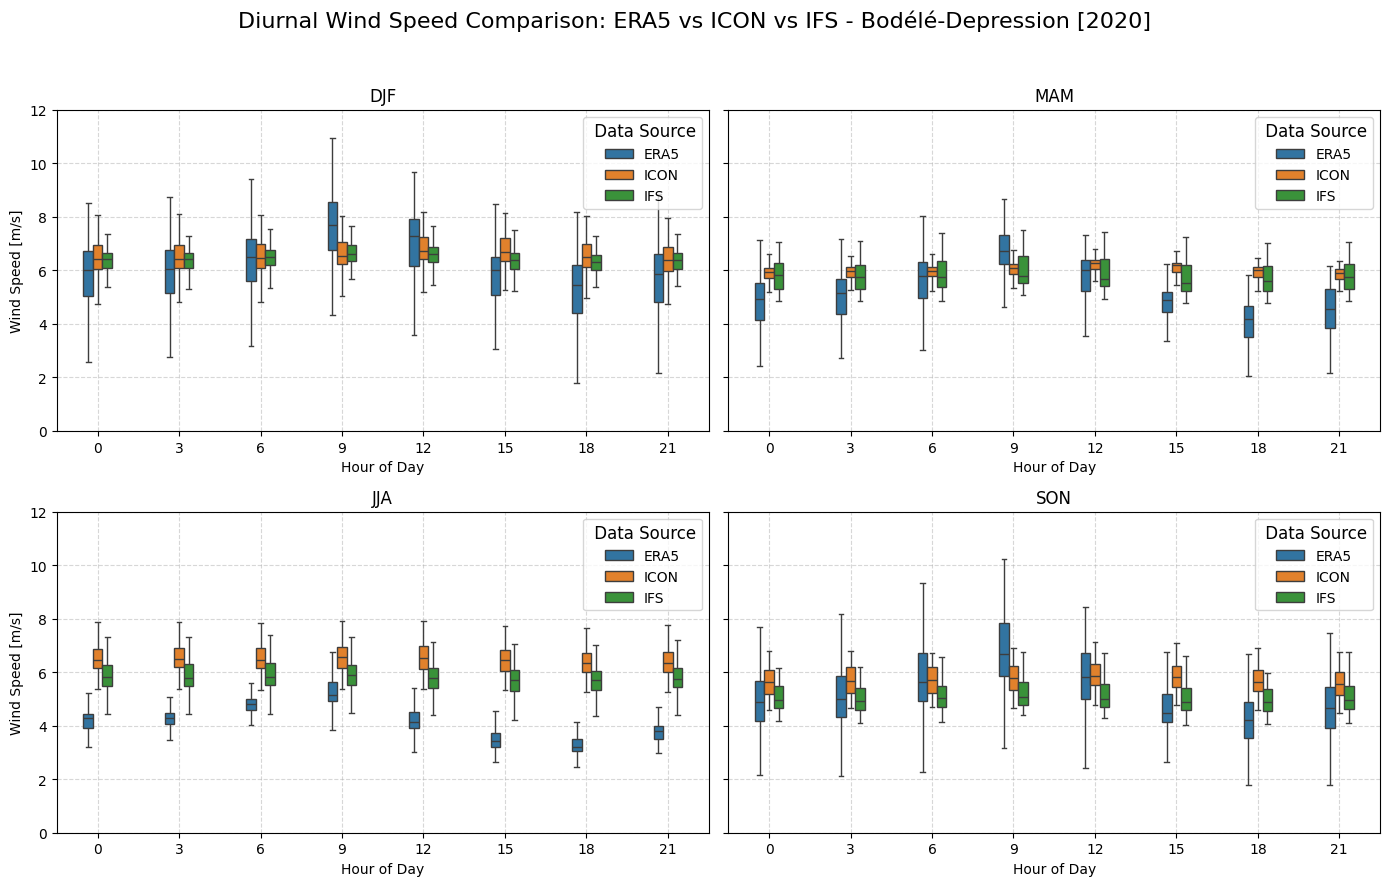

In [11]:


seasons = ["DJF", "MAM", "JJA", "SON"]
fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharey=True)
axes = axes.flatten()
ymin, ymax = 0, 12
box_width = 0.35

for i, season in enumerate(seasons):
    ax = axes[i]
    season_df = df_combined[df_combined["season"] == season]
    
    sns.boxplot(
        x="hour", y="wind_speed", hue="source",
        data=season_df, ax=ax, width=box_width,
        showfliers=False
    )
    
    ax.set_title(f"{season}")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Wind Speed [m/s]" if i in [0, 2] else "")
    ax.set_ylim(ymin, ymax)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(title=" Data Source", loc="upper right", fontsize=10, title_fontsize=12)

# Final layout
fig.suptitle("Diurnal Wind Speed Comparison: ERA5 vs ICON vs IFS - Bodélé-Depression [2020]", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


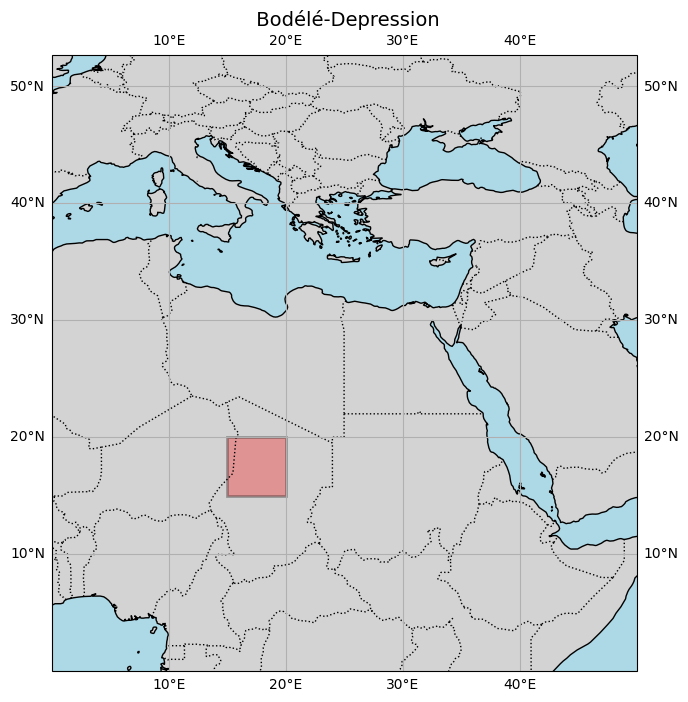

In [ ]:
# === Plotting the region of interest on a map ===

# Define region boundaries
# west_africa
# lat_min, lat_max = 5, 35
# lon_min, lon_max = -18, 5

#bodele
lat_min, lat_max = 15, 20
lon_min, lon_max = 15, 20


# Set up map
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add base features
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS, linestyle=':')
ax.add_feature(cf.LAND, facecolor='lightgray')
ax.add_feature(cf.OCEAN, facecolor='lightblue')
#ax.set_extent([-25, 15, 0, 40])  # wider view around the box
# ✅ Set extent that includes Bodélé
ax.set_extent([0, 50, 0, 50]) 

# Plot shaded region (West Africa box)
ax.add_patch(plt.Rectangle(
    (lon_min, lat_min),               # lower-left corner
    lon_max - lon_min,               # width
    lat_max - lat_min,               # height
    transform=ccrs.PlateCarree(),
    facecolor='red',
    alpha=0.3,
    edgecolor='black',
    linewidth=2
))

# Add labels and grid
ax.set_title(" Bodélé-Depression", fontsize=14)
ax.gridlines(draw_labels=True)

plt.show()



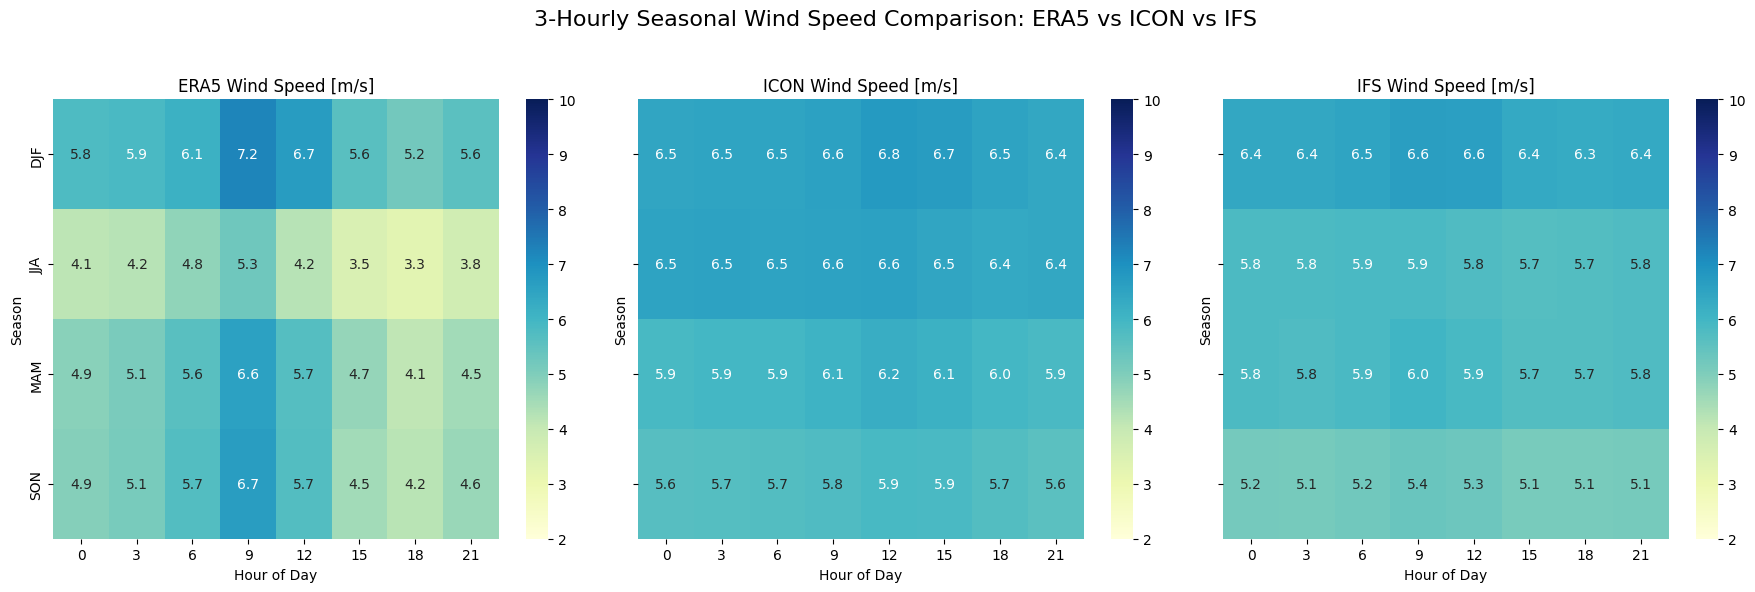

In [ ]:
# === Plotting the  same box plot idea as heat map ===
pivot_df = (
    df_combined.groupby(["source", "season", "hour"])["wind_speed"]
    .mean()
    .reset_index()
)

heatmap_data = {
    source: df.pivot(index="season", columns="hour", values="wind_speed")
    for source, df in pivot_df.groupby("source")

}



fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, (source, data) in zip(axes, heatmap_data.items()):
    sns.heatmap(
        data,
        ax=ax,
        cmap="YlGnBu",
        annot=True,
        fmt=".1f",
        cbar=True,
        vmin=2, vmax=10  # adjust range if needed
    )
    ax.set_title(f"{source} Wind Speed [m/s]")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Season")

plt.suptitle("3-Hourly Seasonal Wind Speed Comparison: ERA5 vs ICON vs IFS", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



In [ ]:
### ploting the difference between the models as heat map########



# === Compute average wind speed per hour and season for each source ===
avg_wind = df_combined.groupby(["season", "hour", "source"])["wind_speed"].mean().reset_index()

# === Pivot to wide format: one column per source ===
pivot_df = avg_wind.pivot_table(index=["season", "hour"], columns="source", values="wind_speed").reset_index()

# === Compute difference ===
pivot_df["diff"] = pivot_df["ERA5"] - pivot_df["ICON"]

# === Pivot for heatmap: rows = season, columns = hour ===
heatmap_data = pivot_df.pivot(index="season", columns="hour", values="diff")
heatmap_data = heatmap_data.reindex(["DJF", "MAM", "JJA", "SON"])  # optional: ensure seasonal order

# === Plot the heatmap ===
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=0.5, cbar_kws={"label": "ERA5 - ICON (m/s)"})
plt.title("Mean Wind Speed Difference (ERA5 - ICON) by Hour and Season [ West Africa (2020)]")
plt.xlabel("Hour of Day")
plt.ylabel("Season")
plt.tight_layout()
plt.show()


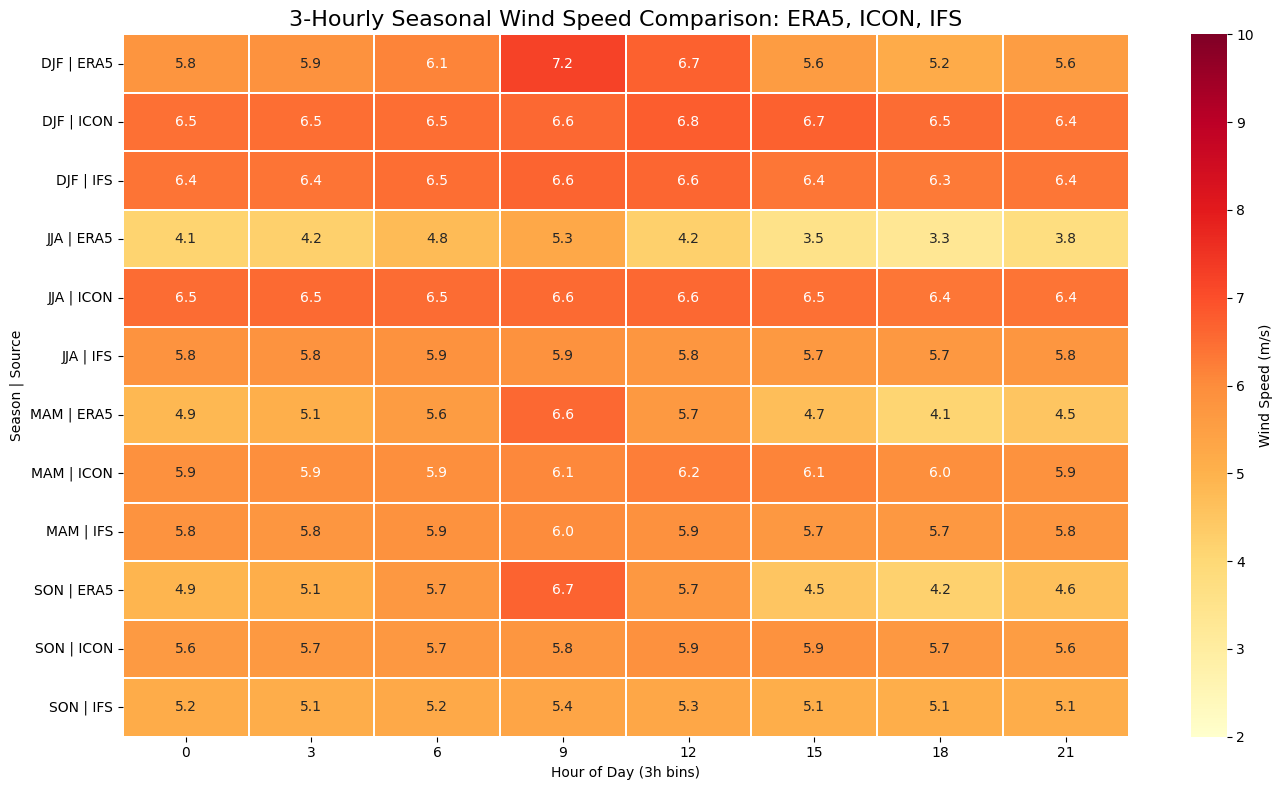

In [ ]:


# Step 1: Group and average wind speed
pivot_df = (
    df_combined.groupby(["source", "season", "hour"])["wind_speed"]
    .mean()
    .reset_index()
)

# Step 2: Create combined y-label
pivot_df["season_source"] = pivot_df["season"] + " | " + pivot_df["source"]

# Step 3: Pivot for heatmap
heatmap_matrix = pivot_df.pivot(index="season_source", columns="hour", values="wind_speed")

# Step 4: Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_matrix,
    cmap="YlOrRd",
    annot=True,
    fmt=".1f",
    linewidths=0.3,
    cbar_kws={'label': 'Wind Speed (m/s)'},
    vmin=2, vmax=10  # adjust range as needed
)

plt.title("3-Hourly Seasonal Wind Speed Comparison: ERA5, ICON, IFS", fontsize=16)
plt.xlabel("Hour of Day (3h bins)")
plt.ylabel("Season | Source")
plt.tight_layout()
plt.show()
